# RL Lab 03 - Part II- Control of finite unknown MDPs

CentraleSupélec Mention IA 2022-2023  
Hédi Hadiji 

In [4]:
# Imports
%matplotlib inline

import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from collections import defaultdict
from itertools import product
from copy import deepcopy

import plotting
from utilities import * 

matplotlib.style.use('ggplot')

In [5]:
# Inline display trick
import time
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

## 1. Monte-Carlo Control

Let us rerun the code from part I.

In [6]:
from gymnasium.spaces import Discrete

class LinearEnv:
    """
    State Index:   [ 0    1    2    3    4    5    6 ]
    State Label:   [ .    A    B    C    D    E    . ]
    Type:          [ T    .    .    S    .    .    T ]    
    """
    V_true =       [0.0, 1/6, 2/6, 3/6, 4/6, 5/6, 0.0] # true values for gamma=1
    
    def __init__(self):
        self.reset()
        self.observation_space = Discrete(7)
        self.action_space = Discrete(2)

    def reset(self):
        self._state = 3
        self._terminated = False
        return self._state, {}

    def step(self, action):
        if action == 0: 
            self._state -= 1
        if action == 1: 
            self._state += 1
            
        reward = 0
        if self._state < 1:
            self._terminated = True
        if self._state > 5: 
            self._terminated = True
            reward = 1
                
        return self._state, reward, self._terminated, False, {}

We now build upon the Monte-Carlo policy evaluation agent that we coded earlier, to get a controller. 


**Question** (Do not scroll down) What is the key new ingredient that we need to implement to switch from policy evaluation to control? 

Answer: 

Policy improvement.

### Description of the algorithm: 

Start with an arbitrary policy.

Run policy Monte-Carlo policy evaluation for N rounds

Change the policy to eps-greedy with respect to the estimated values. 

Repeat. 

**Question** What is the issue with our previous Policy Evaluation algorithm if we want to compute the $\epsilon$-greedy policy associated to it? 

Answer: 

We computed state-value estimates, but we need action-values to compute the greedy policy.

In [7]:
class MCController: 
    """
        Monte-Carlo control
    """
    def __init__(self,
                 action_space,
                 observation_space,
                 gamma=0.99, 
                 eps_init=.5, 
                 eps_min=1e-5,
                 eps_step=1e-3,
                 episodes_between_greedyfication=500,
                 name='MC Controller'
                ):
        
        self.action_space = action_space
        self.observation_space = observation_space
        self.gamma = gamma
        self.name = name

        self.eps = eps_init
        self.eps_min = eps_min
        self.eps_step = eps_step

        self.episodes_between_greedyfication = episodes_between_greedyfication
        self.episode_counter = 0
        
        self.reset()

    def eps_greedy(self, obs, eps=None):
        if eps is None: 
            eps = self.eps

        # Return a greedy action wrt the action values estimates.

        if np.random.random() < self.eps: 
            return self.action_space.sample()
        else:
            b = self.q_values[obs]
            return np.random.choice(np.flatnonzero(b == np.max(b))) # argmax with random tie-breaking
            #return np.argmax(b)
        
    def get_action(self, obs): 
        return self.eps_greedy(obs)
        
    def update(self, obs, action, reward, terminated, next_obs):
        self.current_episode_rewards.append(reward)
        self.current_episode_obs.append((obs, action))
        
        if terminated:
            self._end_of_episode_update()

    def _end_of_episode_update(self):
        current_episode_returns = rewardseq_to_returns(self.current_episode_rewards, self.gamma)
        seen = []
        for i, (state, action) in enumerate(self.current_episode_obs): 
            if (state, action) not in seen: 
                seen.append((state, action))
                return_value = current_episode_returns[i]
                
                n = self.number_of_values_in_estimate[state, action]
                self.values_estimates[state][action] = n / (n + 1) * self.values_estimates[state][action] + 1 / (n+1) * return_value
                self.number_of_values_in_estimate[state, action] += 1
                            
        self.current_episode_rewards = []
        self.current_episode_obs = []

        self.episode_counter += 1 
        
        if self.episode_counter % self.episodes_between_greedyfication == 0:
            new_q_values = defaultdict(lambda: np.zeros(self.action_space.n))
            for state in self.values_estimates: 
                new_q_values[state] = self.values_estimates[state]
            self.reset(q_values=new_q_values)
            self.epsilon_decay()
    
    def epsilon_decay(self):
        self.eps = max(self.eps - self.eps_step, self.eps_min)
            
    def reset(self, q_values=None):
        self.current_episode_rewards = []
        self.current_episode_obs = []

        if q_values is None:
            self.q_values = defaultdict(lambda: np.zeros(self.action_space.n))
        else: 
            self.q_values = q_values

        self.values_estimates = defaultdict(lambda: np.zeros(self.action_space.n))
        self.number_of_values_in_estimate = defaultdict(lambda : 0)

Pay attention to where the decaying in epsilon is done. 

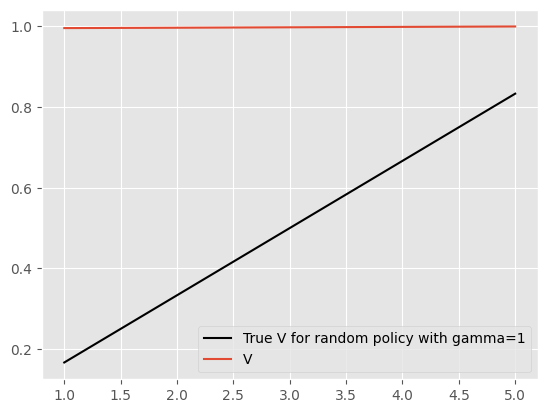

In [8]:
env = LinearEnv()
gamma = .999
N_episodes = 100_000

episodes_between_greedyfication = 20_000

eps_init = .1
eps_step= eps_init * episodes_between_greedyfication / N_episodes

agent = MCController(env.action_space, env.observation_space, eps_init=eps_init, eps_step=eps_step, gamma=gamma, episodes_between_greedyfication=episodes_between_greedyfication)
env, agent = run_N_episodes(env, agent, N_episodes=N_episodes)

plotting.plot_RW([np.max(agent.q_values[obs]) for obs in range(7)])
#plt.plot([np.max(agent.q_values[obs]) for obs in range(7)])
#plt.show()

**Question** What exactly did we plot above? Is it the value of the policy?  

**Answer:**  
We plotted the maximum of the action values estimates 
$$
    \max_{a \in \mathcal A} q(s, a)
$$
where $q$ is an estimator of the optimal action-value. The final policy is ($\eps-)greedy with respect to $q$.

If the estimation has gone well, then our plot should be a `reasonable' estimator for $V_\star$ since
$$
    \max_{a \in \mathcal A} q_\star(s, a) = V_\star(s) 
$$

However, if the estimation has gone wrong then the policy may not be optimal. In that case, the $V$ we plotted is neither $V_\star$, nor the true value of the policy we are playing.

# 2. Q-learning



<img src="img/q-learning-description.png" 
     width="50%" />

In [9]:
class QLearner(): 
    """
        Stores the data and computes the observed returns.
    """
    def __init__(self, 
                 action_space, 
                 observation_space, 
                 gamma=0.99, 
                 lr=0.1,
                 eps_init=.5, 
                 eps_min=1e-5,
                 eps_step=1-3,
                 name='Q-learning'):
        
        self.action_space = action_space
        self.observation_space = observation_space
        self.gamma = gamma
        self.lr = lr
        
        self.eps = eps_init
        self.eps_min = eps_min
        self.eps_step = eps_step

        self.name = name
        
        self.reset()
    
    def eps_greedy(self, obs, eps=None):
        if eps is None: 
            eps = self.eps

        if np.random.random() < self.eps: 
            return self.action_space.sample()
        else:
            b = self.q_values[obs]
            return np.random.choice(np.flatnonzero(b == np.max(b))) # argmax with random tie-breaking
            #return np.argmax(b)
        
    def get_action(self, obs): 
        return self.eps_greedy(obs)
        
    def update(self, obs, action, reward, terminated, next_obs):
        # update the q-values

        estimate_value_at_next_state = (not terminated) * np.max(self.q_values[next_obs])
        new_estimate = reward + self.gamma * estimate_value_at_next_state
        
        self.q_values[obs][action] = (
            (1 - self.lr) * self.q_values[obs][action] 
            + self.lr * new_estimate
        )
        
        self.epsilon_decay()
        
    def epsilon_decay(self):
        self.eps = max(self.eps - self.eps_step, self.eps_min)
        
    def reset(self):
        self.q_values = defaultdict(lambda: np.zeros(self.action_space.n))

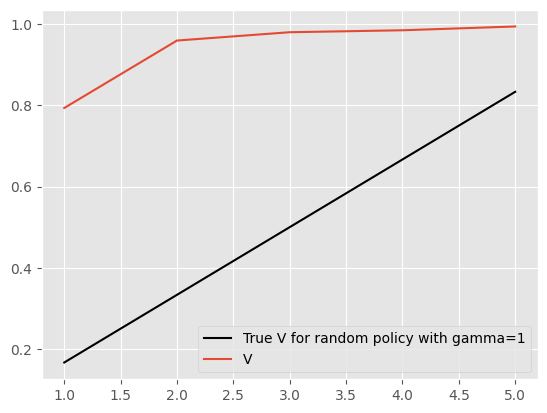

In [10]:
env = LinearEnv()
lr = 0.1
gamma = 0.9999

N_episodes = 100
eps_init = .5
eps_step = 10 / N_episodes

agent = QLearner(env.action_space, env.observation_space, gamma=gamma, lr=lr)
env, agent = run_N_episodes(env, agent, N_episodes=N_episodes)

plotting.plot_RW([np.max(agent.q_values[obs]) for obs in range(7)])

# Other Environments

Now that we have tested our two algorithms on a toy environment. Let us try on more sophisticated ones.

In [11]:
env = gym.make("Blackjack-v1", sab=True)
lr = 0.01
gamma = .99
N_episodes = 100_000

eps_init = .5
eps_step = 2 * eps_init / N_episodes

agent = QLearner(env.action_space, env.observation_space, gamma=gamma, lr=lr)
env, agent = run_N_episodes(env, agent, N_episodes=N_episodes)

**Question** Can you find values of hyperparameters that converge to the optimal policy? 

In [12]:
# Answer

# Values to get a close-to-optimal policy: 

# lr = 0.001  
# gamma = .9999  
# N_episodes = 1_000_000  

# eps_init = .5  
# eps_step = 2 * eps_init / N_episodes  

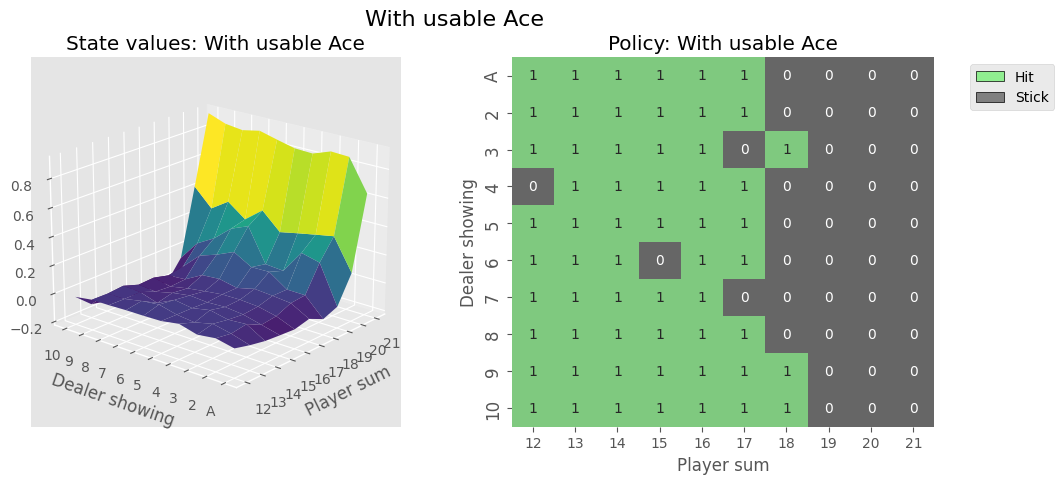

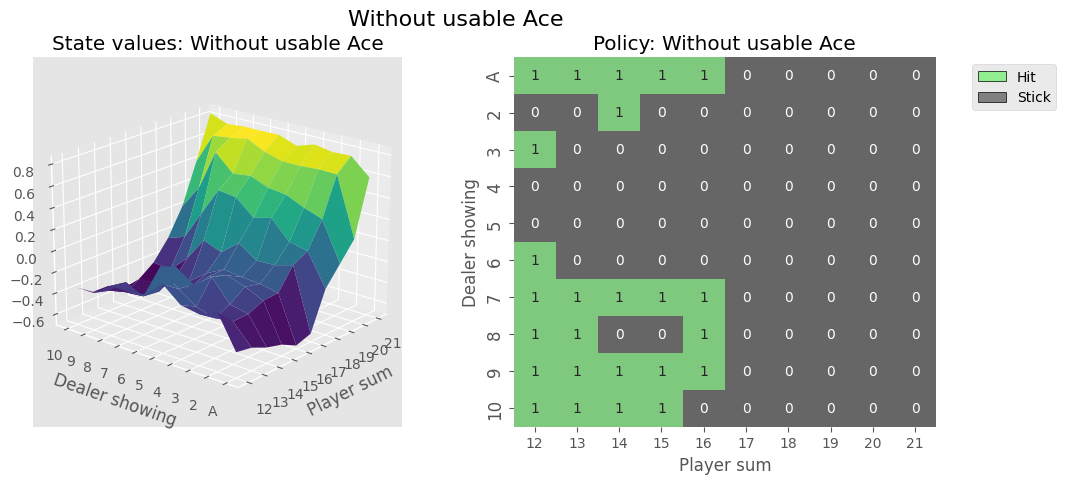

In [13]:
value_grid, policy_grid = plotting.create_grids(agent, usable_ace=True)
plotting.create_plots(value_grid, policy_grid, title="With usable Ace")

value_grid, policy_grid = plotting.create_grids(agent, usable_ace=False)
plotting.create_plots(value_grid, policy_grid, title="Without usable Ace")
plt.show()

## Now do the same with the Monte-Carlo Controller

**(Open) question** (it's not super interesting but I don't have an answer)
Can you find a set of hyperparameters to make it converge to the optimal policy?

In [14]:
env = gym.make("Blackjack-v1", sab=True)
gamma = .9999
N_episodes = 100_000
episodes_between_greedyfication = 30_000

eps_init = .5
eps_step= eps_init * episodes_between_greedyfication / N_episodes

agent = MCController(env.action_space, env.observation_space, eps_init=eps_init, eps_step=eps_step, gamma=gamma, episodes_between_greedyfication=episodes_between_greedyfication)
env, agent = run_N_episodes(env, agent, N_episodes=N_episodes)

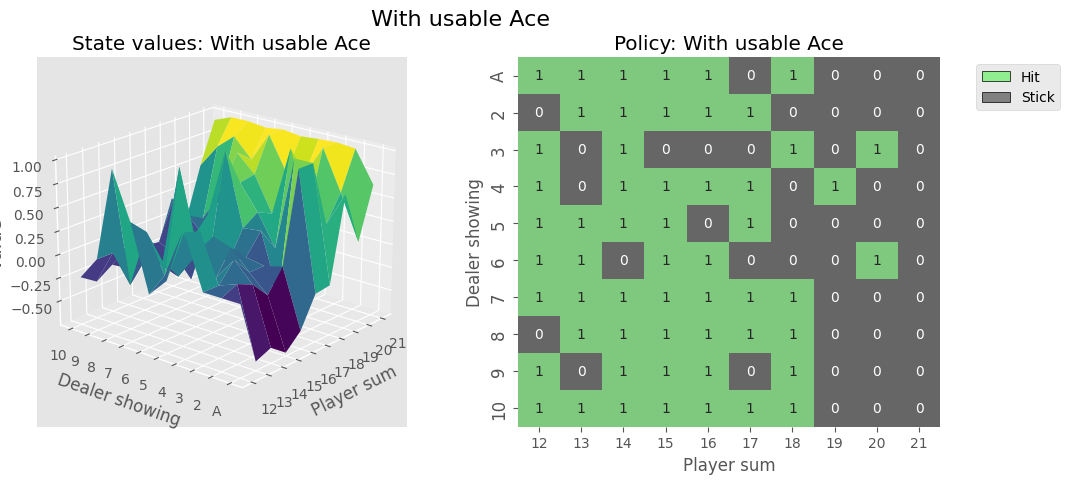

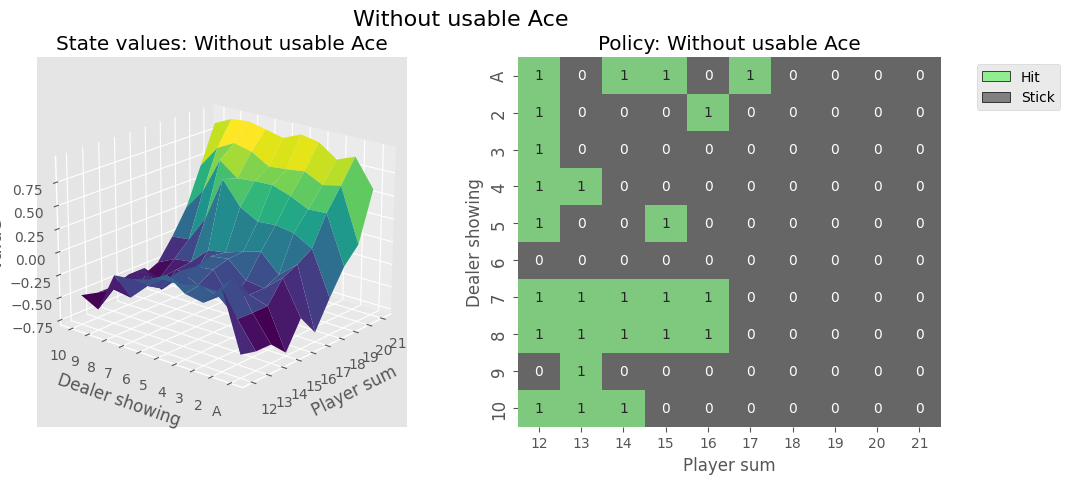

In [15]:
value_grid, policy_grid = plotting.create_grids(agent, usable_ace=True)
plotting.create_plots(value_grid, policy_grid, title="With usable Ace")

value_grid, policy_grid = plotting.create_grids(agent, usable_ace=False)
plotting.create_plots(value_grid, policy_grid, title="Without usable Ace")
plt.show()

**Question:**  Which do you prefer?  

Answer: 

It's your choice. Monte-Carlo is harder to tune here.

# Testing Policies

Gymnasium provides wrappers to environments to record data. The RecordEpisodeStatistics wrapper adds (for example) a return_queue attribute to the environment that stores the returns received. 

In [16]:

def test(agent, env, n_episodes=100): # Test the greedy policy for the q-function learned by the agent
    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in range(n_episodes):
        obs, info = env.reset()
        done = False

        while not done:
            action = agent.eps_greedy(obs, eps=0)
            next_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            obs = next_obs

    return env

def plot_test_stats(env, agent, plot=False):
    returns = np.array(env.return_queue).flatten()
    N_ep = len(returns)
    print('Mean return over n={} episodes : {} +/- {}'.format(N_ep, np.mean(returns), np.std(returns)/np.sqrt(N_ep)))
    ep_lengths = np.array(env.length_queue).flatten()
    print('Mean episode length over n={} episodes : {}'.format(N_ep, np.mean(ep_lengths), np.std(ep_lengths)/np.sqrt(N_ep)))
    
    if plot: 
        fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
        axs[0].set_title("Episode rewards")
        axs[0].axvline(x=np.mean(returns), linestyle='--', alpha=0.5)
        axs[0].hist(returns)

        axs[1].set_title("Episode lengths")
        axs[1].hist(ep_lengths)
        axs[1].axvline(x=np.mean(ep_lengths))

        plt.tight_layout()
        plt.show()

In [17]:
env = gym.make("Blackjack-v1", sab=True)
lr = 0.1
gamma = .99
N_episodes = 500_000

eps_init = .1
eps_step = 10 / N_episodes

agent = QLearner(env.action_space, env.observation_space, gamma=gamma, lr=lr)
env, agent = run_N_episodes(env, agent, N_episodes=N_episodes)

Mean return over n=100 episodes : -0.4399999976158142 +/- 0.08867919445037842
Mean episode length over n=100 episodes : 1.34


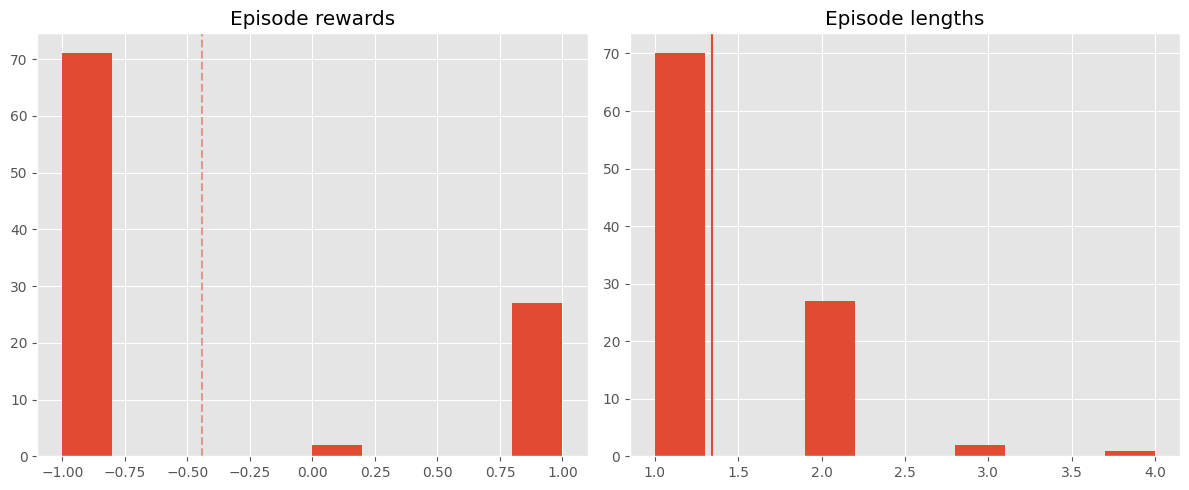

In [18]:
env = test(agent, env, n_episodes=100)
plot_test_stats(env, agent, plot=True)

# Frozen Lake

Train an agent on the Frozen Lake environemnt.

Mean return over n=100 episodes : 0.03999999910593033 +/- 0.019595919549465178
Mean episode length over n=100 episodes : 8.42


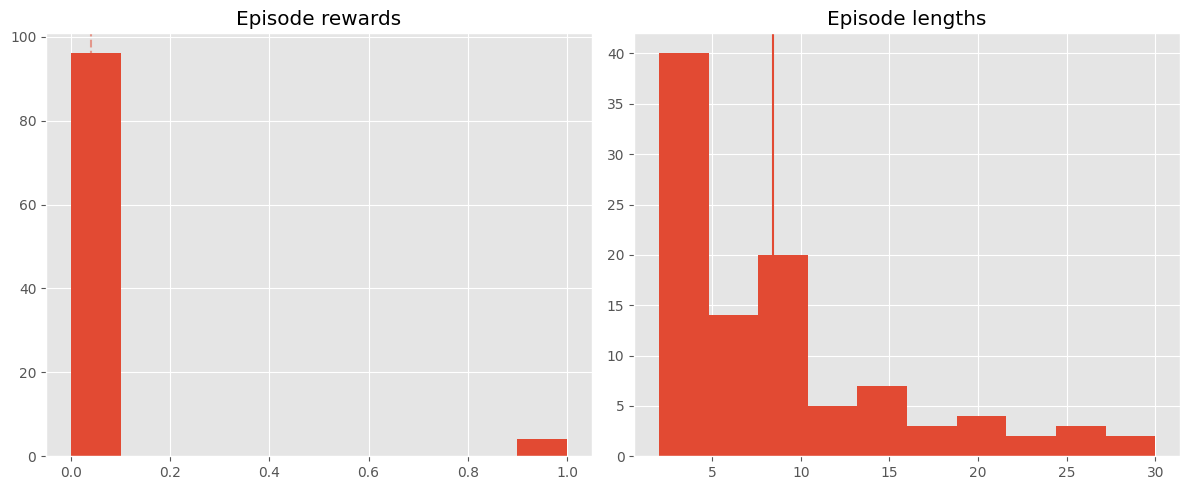

In [19]:
env = gym.make("FrozenLake-v1", render_mode="rgb_array")
lr = 0.01
gamma = .99

N_episodes = 100_000
eps_init = .1
eps_step = 2 * eps_init / N_episodes

agent = QLearner(env.action_space, env.observation_space, eps_init=eps_init, eps_step=eps_step, gamma=gamma, lr=lr)
env = test(agent, env, n_episodes=100)
plot_test_stats(env, agent, plot=True)

In [20]:
env = gym.make("FrozenLake-v1", render_mode="rgb_array")
env, agent = run_N_episodes(env, agent, N_episodes=N_episodes)

Mean return over n=100 episodes : 0.1599999964237213 +/- 0.03666060864925384
Mean episode length over n=100 episodes : 25.29


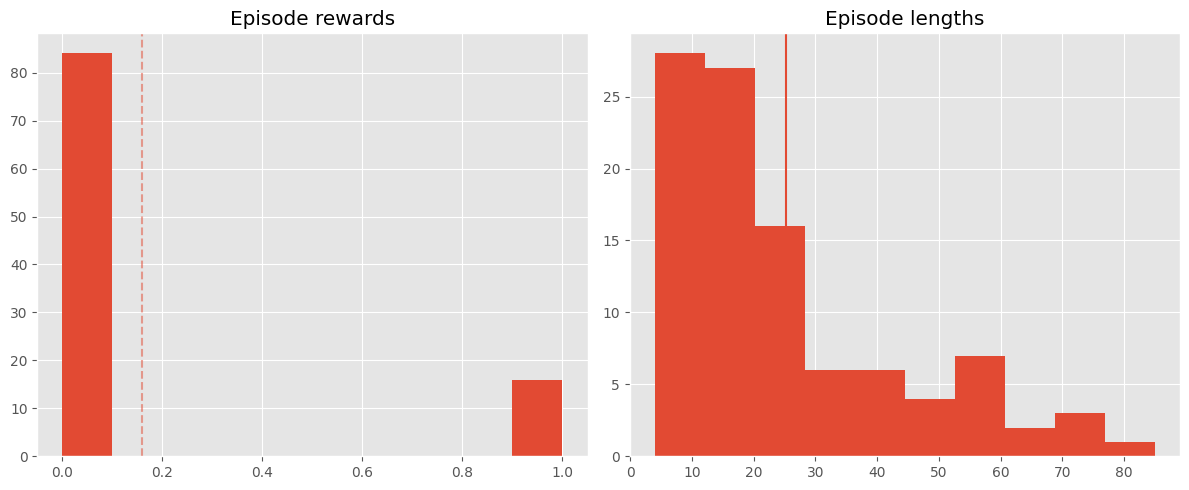

In [21]:
env = gym.make("FrozenLake-v1", render_mode="rgb_array")
env = test(agent, env, n_episodes=100)
plot_test_stats(env, agent, plot=True)

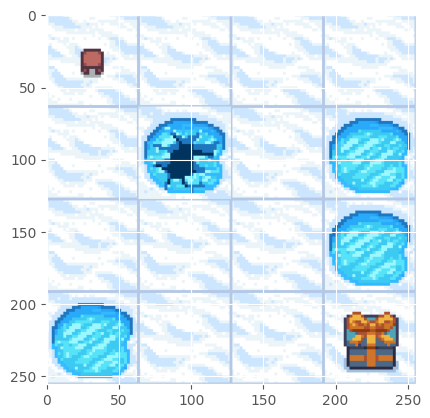

In [22]:
obs, _ = env.reset()
done = False
while not done: 
    action = agent.eps_greedy(obs, eps=0)
    obs, _, terminated, truncated, _ = env.step(action)
    
    done = terminated or truncated

    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()

#### Plotting the policy

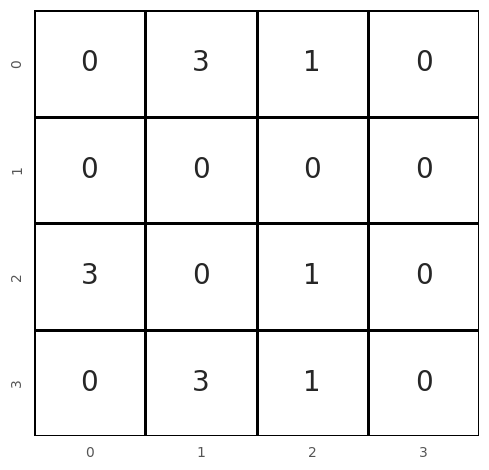

In [23]:
from matplotlib.colors import ListedColormap
import seaborn as sns

#(0, 1, 2, 3) is  (left, down, up, right)

value_grid = np.zeros((4, 4))
for i, j in product(range(4), range(4)):
        value_grid[i, j] = np.argmax(agent.q_values[i * 4 + j])
        
fig = plt.figure(figsize=plt.figaspect(.5))
fig.add_subplot(1, 2, 1)
ax1 = sns.heatmap(value_grid, annot=True, cbar=False, 
                  cmap=ListedColormap(['white']), linecolor='black', linewidth=1,
                 annot_kws={"size": 20})

ax1.tick_params(left=False, bottom=False)
plt.tight_layout()
plt.show()


<img src="img/almost_optimal_fr_lake.png" 
     width="30%" />